In [1]:
# notebooky stuff
%load_ext autoreload
%autoreload 2
from IPython.display import display
import sys 
sys.path.append('../../modules')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import eumf_data, eumf_eval, eumf_pipeline, eumf_custom_models
from sklearn import compose, pipeline, decomposition, cross_decomposition, preprocessing, linear_model, model_selection, ensemble, feature_selection
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
import seaborn as sns
from tqdm import tqdm
import statsmodels.api as sm
import itertools
import mlxtend.feature_selection as mlxfs

# pandas pretty output
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# list of countries
countries = eumf_data.get_countries()
countries.remove("CY")

# migration rates
df_values = eumf_data.load_registrations_from_csv(impute_missing=True, countries=countries)

# google trends
df_trends = eumf_data.load_trends_from_csv(countries=countries)
keyword_ids = df_trends.columns.levels[0].tolist()

# macroeconomic data
df_gdp = eumf_data.read_gdp(countries=countries)
df_unempl = eumf_data.read_unempl(countries=countries)

country_combinations = [
    # ["GR", "CY"],
    ["LV", "LT", "EE"],
    ["BE", "NL", "LU"],
    ["CZ", "SK"],
    ["SE", "FI", "DK"],
    ["AT", "CH"]
]

panel = df_values.join(df_trends, how="outer")
panel_3m = panel.resample("3M", closed="left").mean()

panel_comb = eumf_data.combine_countries(panel, combinations=country_combinations)
panel_comb_3m = eumf_data.combine_countries(panel_3m, combinations=country_combinations)
df_gdp_comb = eumf_data.combine_countries(df_gdp, combinations=country_combinations)
df_unempl_comb = eumf_data.combine_countries(
    df_unempl, combinations=country_combinations, average=True
)
# note: strictly, unweighted average is wrong for unemployment, but should work in most cases

panel_comb_3m_macro = panel_comb_3m.join(df_gdp_comb).join(df_unempl_comb)

panel_comb_3m_macro["2017":"2018"]


/home/stei509/eu_migration_forecast/notebooks/final_paper/../../modules/eumf_data.py:238: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)
/home/stei509/eu_migration_forecast/notebooks/final_paper/../../modules/eumf_data.py:279: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)


10                                                                                                                       11                                                                                                                                            112                                                                                                               ...   value                                                                                                                                     gdp                                                                                                                                                unempl                                                                                                      
            AT+CH  BE+NL+LU  BG  CZ+SK    ES      FR      GB    GR   HR   HU   IE     IT   LV+LT+EE    PL    PT   RO  SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR     HR      HU      IE      IT   LV+LT+EE    PL      PT      RO   SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK      ES      FR      GB      GR      HR      HU      IE      IT   LV+LT+EE    PL    ...     ES        FR        GB        GR        HR        HU       IE        IT     LV+LT+EE     PL        PT        RO     SE+FI+DK    SI     AT+CH   BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR      HR      HU      IE       IT   LV+LT+EE    PL      PT      RO   SE+FI+DK    SI   AT+CH  BE+NL+LU  BG  CZ+SK   ES   FR   GB    GR    HR   HU   IE    IT  LV+LT+EE  PL   PT   RO  SE+FI+DK  SI 
date                                                                                                                                                                                                                                                                                                                                                                                                   ...                                                                                                                                                                                                                                                                                                                                                                                                            
2017-03-31  10.524  16.048   0.0   0.0  26.667  21.857  21.381  0.0  0.0  0.0  0.0  14.095    0.0     6.095  0.0  0.0  21.286   0.0  34.714  60.190    2.190  10.857  38.714  29.810  53.381  10.000  0.000   0.619  11.095  22.048    0.0    11.952  12.714  11.571  26.524   0.0  97.190  178.952  42.238  127.048  33.143  63.333  47.286   9.000  63.095  62.810  59.333  14.905  179.429  39.524  ...  1689.000  1268.333  1080.333  2327.333  4459.000  3747.667  156.000  5255.333  1396.333  12264.667  866.333  18186.333  654.333  420.333  28780.0  42970.0  1510.0  7620.0  5950.0  8450.0  9080.0  3760.0  2590.0  2820.0  14640.0  6800.0  10490.0  2760.0  4520.0  1850.0  33780.0  4790.0  2.85    6.433   6.6  6.00  18.2  9.6  4.6  22.4  12.7  4.3  7.4  11.6   7.333   5.3  9.8  5.3   7.167   7.4
2017-06-30   4.952  14.810   0.0   0.0  21.048  13.952  18.857  0.0  0.0  0.0  0.0  15.286    0.0     6.524  0.0  0.0  27.714   0.0  39.286  61.619   10.619   7.714  24.381  27.952  55.714   4.714  2.333   7.095  20.619  17.286    0.0    13.810  23.143  11.143  32.857   0.0  85.619  168.905  35.190   83.429  23.810  57.857  48.000  11.905  33.048  27.905  62.810  14.286  126.667  21.476  ...  1427.667  1023.333  1049.000  2113.333  4121.333  3637.667  164.667  4699.000  1407.000  12940.000  609.667  19264.000  520.333  365.000  29250.0  44540.0  1800.0  8470.0  6330.0  8560.0  8980.0  4120.0  2990.0  3200.0  14700.0  7140.0  11780.0  2960.0  4790.0  2200.0  35590.0  5260.0  2.70    5.867   6.2  5.75  17.3  9.6  4.4  21.8  11.5  4.3  6.7  11.3   7.667   5.1  9.2  4.9   7.133   6.6
2017-09-30   4.905  16.095   0.0   0.0  12.429  21.048  16.

In [3]:
# migration rates
df_values = eumf_data.load_registrations_from_csv(impute_missing=True)

# google trends
df_trends = eumf_data.load_trends_from_csv()

countries = eumf_data.get_countries()
keyword_ids = df_trends.columns.levels[0].tolist()

df_gdp = eumf_data.read_gdp()
df_unempl = eumf_data.read_unempl()


/home/stei509/eu_migration_forecast/notebooks/final_paper/../../modules/eumf_data.py:238: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)
/home/stei509/eu_migration_forecast/notebooks/final_paper/../../modules/eumf_data.py:279: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)


In [4]:
T_MIN = "2010"
T_MAX = "2019"

T_TEST_MIN = "2019"
T_TEST_MAX = "2019"

cv_default = eumf_eval.BlockKFold(n_splits=8, margin=1.0)
cv_random = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
# n_countries = len(panel_comb_3m_macro["value"].columns)
# cv_time = model_selection.TimeSeriesSplit(test_size=4 * n_countries, n_splits=6)

## Pre-selection and analysis

Spearman correlation with target

In [5]:

labeled = eumf_pipeline.prepare_data(
    panel_comb_3m_macro,
    columns=["value", "gdp", "unempl"] + keyword_ids,
    lags=[1, 2, 3, 4, 5, 6, 7, 8],
    alternate_lags={
        "value": [2, 3, 4, 5, 6, 7, 8],
        "gdp": [2, 3, 4, 5, 6, 7, 8],
        "unempl": [2, 3, 4, 5, 6, 7, 8],
    },
    t_min=T_MIN,
    t_max=T_MAX,
)
transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test, extra_column=False)

records = []
for c in train_stacked.x.columns:
    record = {
        "feature": c.split("_")[0],
        "lag": int(c.split("_")[1]),
        "spearman_p": spearmanr(train_stacked.x[c], train_stacked.y).pvalue,
        "spearman_r": spearmanr(train_stacked.x[c], train_stacked.y).statistic,
    }
    records.append(record)

df_spearman = pd.DataFrame(records)


In [19]:
len(train_stacked.x)

576

<Axes: xlabel='feature', ylabel='lag'>

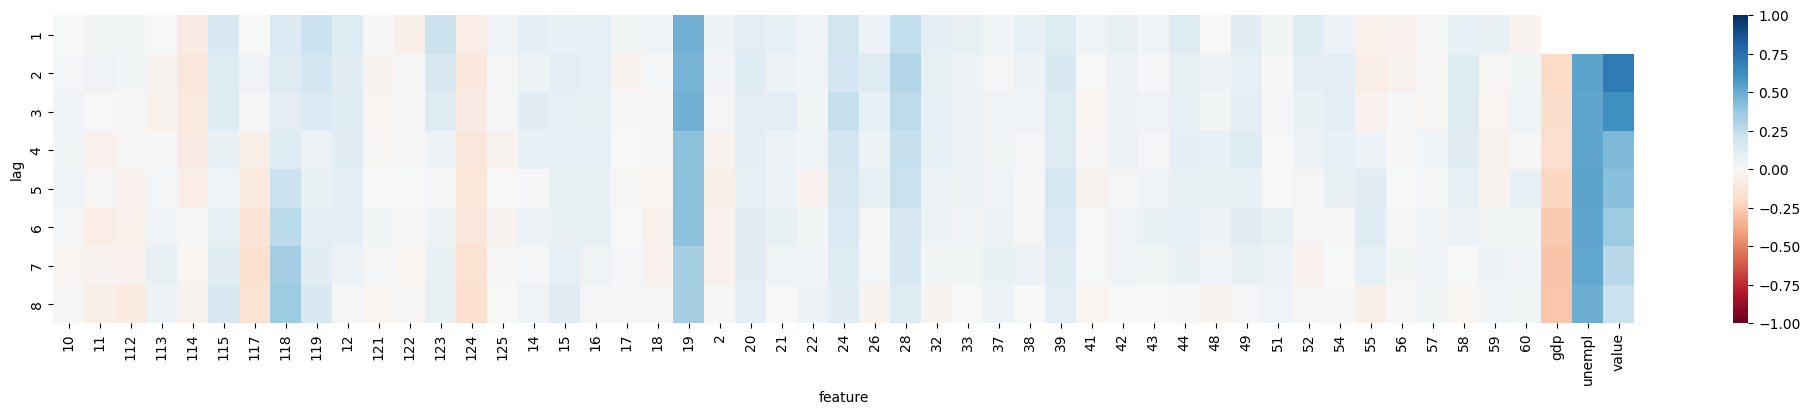

In [6]:
plt.figure(figsize=(0.5*(len(keyword_ids)+3), 4))
sns.heatmap(df_spearman.pivot_table(values="spearman_r", columns="feature", index="lag"), cmap="RdBu", vmin=-1, vmax=1)

In [7]:
opt_p = df_spearman.groupby("feature").min()["spearman_p"]
opt_others = df_spearman.iloc[
    df_spearman.groupby("feature").idxmin()["spearman_p"]
].set_index("feature")[["lag", "spearman_r"]]
pd.concat([opt_p, opt_others], axis=1).sort_values(by="spearman_p", ascending=True)


,spearman_p,lag,spearman_r
feature,,,
value,1.992e-88,2,0.707
unempl,1.490e-44,5,0.538
19,3.419e-35,3,0.484
118,2.669e-19,8,0.362
28,6.277e-13,2,0.294
gdp,2.195e-12,7,-0.287
24,5.156e-09,3,0.240
123,2.197e-07,1,0.214
119,2.602e-07,1,0.213


Analyze multicollinearity

In [8]:

labeled = eumf_pipeline.prepare_data(
    panel_comb_3m_macro,
    columns=["gdp", "unempl"] + keyword_ids,
    lags=[1],
    t_min=T_MIN,
    t_max=T_MAX,
)

transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test, extra_column=False)

X=train_stacked.x


In [9]:
X.corr("spearman").stack().replace(1.0,0.0).drop_duplicates().sort_values(ascending=False)

119_1  123_1       0.523
112_1  124_1       0.486
121_1  124_1       0.337
19_1   unempl_1    0.334
       28_1        0.300
115_1  unempl_1    0.298
112_1  121_1       0.291
115_1  118_1       0.286
117_1  122_1       0.259
114_1  121_1       0.258
                   ...  
56_1   59_1       -0.141
123_1  gdp_1      -0.145
117_1  unempl_1   -0.147
10_1   56_1       -0.149
2_1    56_1       -0.157
122_1  unempl_1   -0.171
19_1   gdp_1      -0.173
115_1  gdp_1      -0.180
124_1  unempl_1   -0.237
gdp_1  unempl_1   -0.583
Length: 1226, dtype: float64

In [10]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [
    variance_inflation_factor(X.values, i) for i in range(len(X.columns))
]

vif_data.sort_values(by="VIF", ascending=False)


,feature,VIF
12,124_1,2.569
49,unempl_1,2.353
48,gdp_1,2.121
1,112_1,1.961
11,123_1,1.831
33,41_1,1.713
7,119_1,1.631
20,19_1,1.595
26,28_1,1.540
14,12_1,1.441


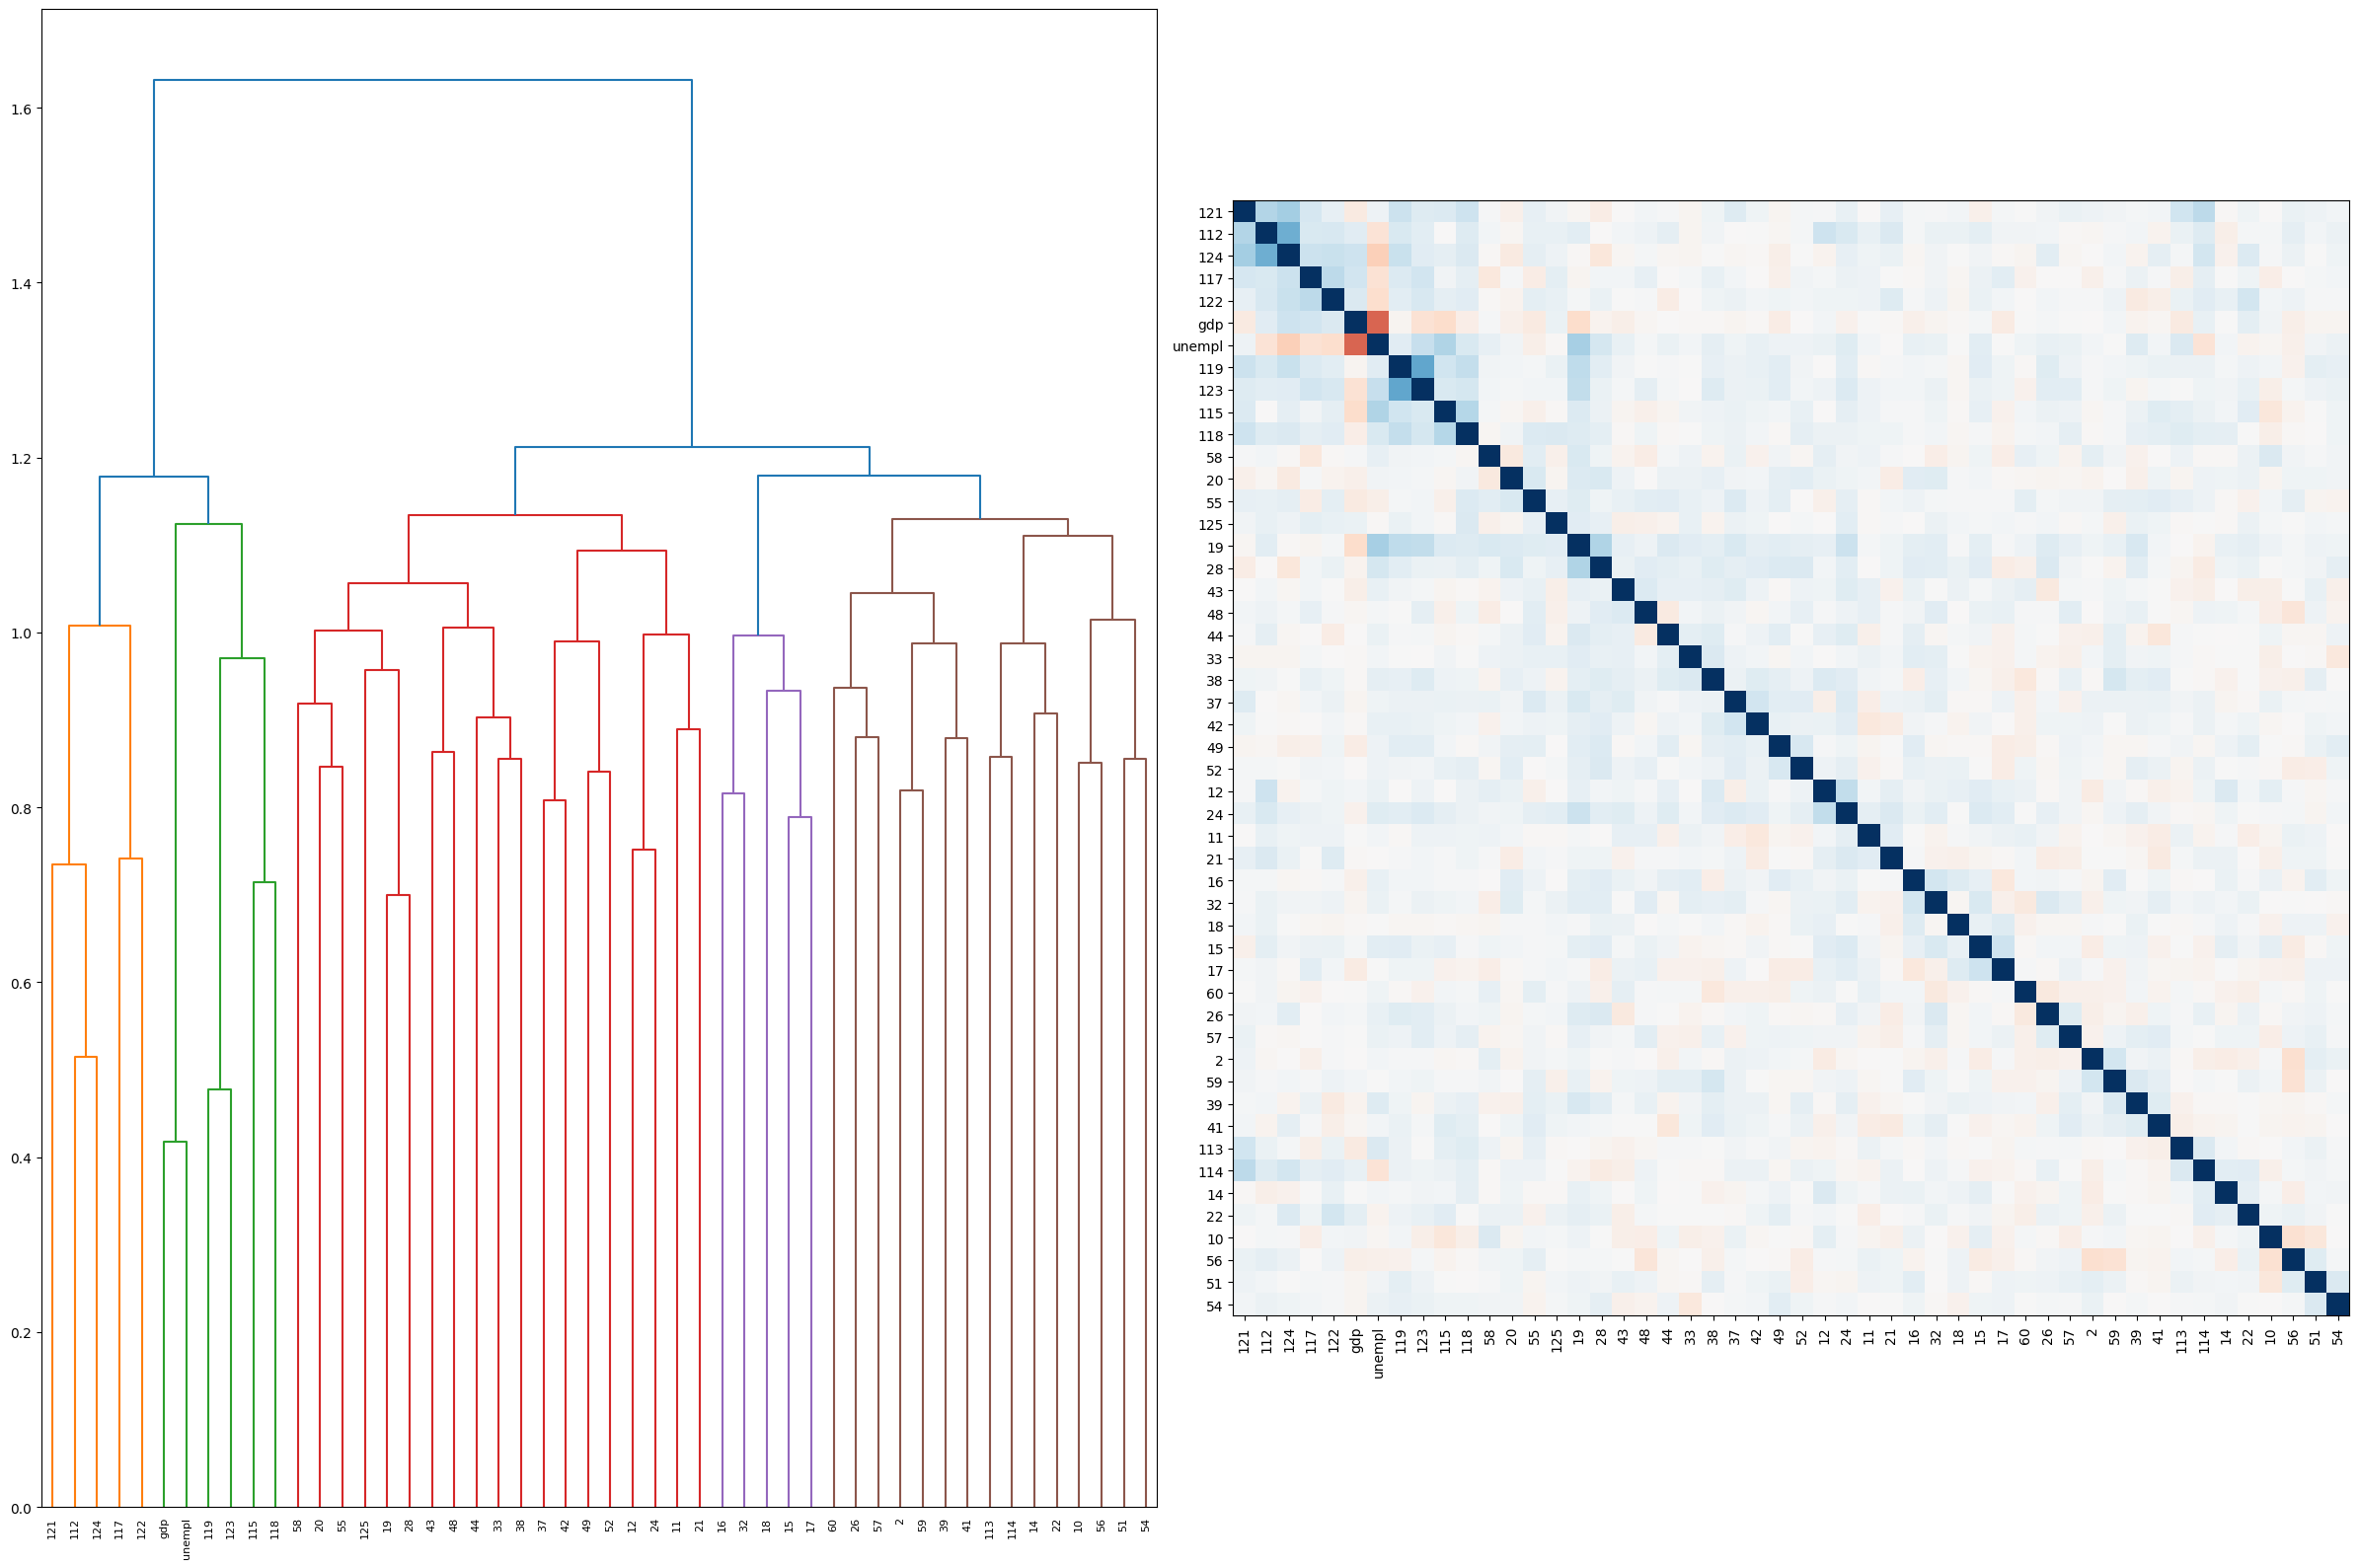

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 16))

corr = spearmanr(X).correlation
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=[s[:-2] for s in X.columns], ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]], cmap="RdBu", vmin=-1, vmax=1)
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()



full multicollinearity with all lags

In [81]:
selected_keyword_ids = [
    "19",
    "118",
    "28",
    "24",
    "123",
    "119",
    "39",
    "115",
    "124",
    "117",
]

labeled = eumf_pipeline.prepare_data(
    panel_comb_3m_macro,
    columns=["value", "gdp", "unempl"] + selected_keyword_ids,
    lags=[1, 2, 3, 4, 5, 6, 7, 8],
    alternate_lags={
        "value": [2, 3, 4, 5, 6, 7, 8],
        "gdp": [2, 3, 4, 5, 6, 7, 8],
        "unempl": [2, 3, 4, 5, 6, 7, 8],
    },
    t_min=T_MIN,
    t_max=T_MAX,
)

transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test, extra_column=False)

selected_variables=selected_keyword_ids + ["unempl", "gdp", "value"]

feature_order = (
    df_spearman[
        df_spearman["feature"].isin(selected_variables)
    ]
    .sort_values(by="spearman_r", ascending=False)
    .apply(lambda x: x["feature"] + "_" + str(x["lag"]), axis="columns")
    .to_list()
)

X = train_stacked.x[feature_order]

feature_order

['value_2',
 'value_3',
 'unempl_5',
 'unempl_2',
 'unempl_6',
 'unempl_4',
 'unempl_3',
 'unempl_7',
 'unempl_8',
 '19_3',
 '19_1',
 '19_2',
 'value_4',
 'value_5',
 '19_4',
 '19_5',
 '19_6',
 'value_6',
 '118_8',
 '19_7',
 '118_7',
 '19_8',
 '28_2',
 'value_7',
 '118_6',
 '28_3',
 '28_1',
 '24_3',
 '28_4',
 '28_5',
 'value_8',
 '118_5',
 '123_1',
 '119_1',
 '24_1',
 '24_4',
 '24_2',
 '119_2',
 '39_5',
 '24_5',
 '123_2',
 '28_6',
 '115_8',
 '115_1',
 '28_7',
 '39_2',
 '119_8',
 '119_3',
 '24_6',
 '118_1',
 '39_6',
 '115_2',
 '39_1',
 '118_2',
 '39_4',
 '39_3',
 '28_8',
 '123_3',
 '39_7',
 '24_7',
 '115_3',
 '118_4',
 '119_7',
 '115_7',
 '24_8',
 '39_8',
 '118_3',
 '119_6',
 '115_6',
 '123_8',
 '119_5',
 '115_4',
 '123_7',
 '119_4',
 '123_4',
 '123_6',
 '115_5',
 '117_2',
 '117_3',
 '123_5',
 '117_1',
 '117_4',
 '124_1',
 '124_3',
 '117_5',
 '124_2',
 '124_4',
 '124_6',
 '124_5',
 '117_6',
 '117_8',
 '124_7',
 '117_7',
 '124_8',
 'gdp_4',
 'gdp_3',
 'gdp_2',
 'gdp_5',
 'gdp_6',
 'gdp_8

In [82]:
X.corr("spearman").stack().replace(1.0,0.0).drop_duplicates().sort_values(ascending=False).head(50)

unempl_6  unempl_7    0.922
unempl_5  unempl_6    0.921
          unempl_4    0.918
unempl_7  unempl_8    0.918
unempl_4  unempl_3    0.915
unempl_2  unempl_3    0.913
unempl_5  unempl_7    0.862
unempl_6  unempl_4    0.860
unempl_2  unempl_4    0.855
unempl_5  unempl_3    0.855
unempl_6  unempl_8    0.852
gdp_3     gdp_2       0.812
gdp_4     gdp_3       0.806
value_4   value_5     0.806
value_2   value_3     0.806
value_3   value_4     0.804
gdp_8     gdp_7       0.794
value_5   value_6     0.793
unempl_5  unempl_2    0.790
unempl_4  unempl_7    0.790
unempl_6  unempl_3    0.789
value_6   value_7     0.786
gdp_6     gdp_7       0.785
value_7   value_8     0.782
gdp_5     gdp_6       0.779
unempl_5  unempl_8    0.779
gdp_4     gdp_5       0.770
119_8     119_7       0.709
119_7     119_6       0.700
value_3   value_5     0.694
value_2   value_4     0.694
119_3     119_4       0.688
value_5   value_7     0.687
value_4   value_6     0.687
unempl_2  unempl_6    0.687
119_6     119_5     

In [93]:
from collections import defaultdict
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))


cluster_ids = hierarchy.fcluster(dist_linkage, 0.5, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_indices = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features = X.columns.to_series().reset_index(drop=True).iloc[selected_indices]
selected_features

0      value_2
2     unempl_5
9         19_3
10        19_1
11        19_2
14        19_4
15        19_5
16        19_6
17     value_6
18       118_8
19        19_7
21        19_8
22        28_2
24       118_6
25        28_3
26        28_1
27        24_3
28        28_4
29        28_5
31       118_5
32       123_1
33       119_1
34        24_1
35        24_4
36        24_2
38        39_5
39        24_5
41        28_6
42       115_8
43       115_1
44        28_7
45        39_2
46       119_8
47       119_3
48        24_6
49       118_1
50        39_6
51       115_2
52        39_1
53       118_2
54        39_4
55        39_3
56        28_8
58        39_7
59        24_7
60       115_3
61       118_4
63       115_7
64        24_8
65        39_8
66       118_3
67       119_6
68       115_6
69       123_8
71       115_4
74       123_4
76       115_5
77       117_2
78       117_3
80       117_1
81       117_4
82       124_1
83       124_3
84       117_5
87       124_6
89       117_6
90       1

In [94]:
vif_data = pd.DataFrame()
vif_data["feature"] = selected_features

vif_data["VIF"] = [
    variance_inflation_factor(X[selected_features].values, i)
    for i in range(len(selected_features))
]

vif_data.sort_values(by="VIF", ascending=False)


,feature,VIF
97,gdp_5,4.597
94,gdp_4,4.493
2,unempl_5,4.236
31,118_5,3.307
67,119_6,3.203
11,19_2,3.062
0,value_2,3.047
61,118_4,3.041
87,124_6,3.014
9,19_3,2.998


## Feature selection

### Recursive Feature Elimination with RF

prior hypertuning

In [117]:
### TRAINING

# rough tuning already performed, this is the final search space
params = {
    "randomforestregressor__max_features": [None],
    "randomforestregressor__min_samples_leaf": [4, 6, 8, 10, 12],
    "randomforestregressor__min_samples_split": [2, 4, 8],
}

labeled = eumf_pipeline.prepare_data(
    panel_comb_3m_macro,
    columns=["value", "gdp", "unempl"] + selected_keyword_ids,
    lags=[1, 2, 3, 4, 5, 6, 7, 8],
    alternate_lags={
        "value": [2, 3, 4, 5, 6, 7, 8],
        "gdp": [2, 3, 4, 5, 6, 7, 8],
        "unempl": [2, 3, 4, 5, 6, 7, 8],
    },
    t_min=T_MIN,
    t_max=T_MAX,
)
labeled.x = labeled.x[selected_features]
transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)


tuner = eumf_pipeline.train_reg_model(
    train_stacked,
    reg=ensemble.RandomForestRegressor(random_state=42),
    extra_pipeline_steps=[preprocessing.StandardScaler()],
    params=params,
    scoring=eumf_eval.scorer_mae,
    cv=cv_default,
    random_iterations=20,
)

cv_score = eumf_eval.score_cv(
    tuner.best_estimator_,
    train_stacked,
    cv=cv_default,
)

test_score = eumf_eval.score_test(
    tuner.best_estimator_,
    test_stacked,
)


/home/stei509/eu_migration_forecast/.venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 15 is smaller than n_iter=20. Running 15 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [118]:
pd.DataFrame(tuner.cv_results_).sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestregressor__min_samples_split,param_randomforestregressor__min_samples_leaf,param_randomforestregressor__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
9,4.188,0.237,0.070,0.043,2,10,None,{'randomforestregressor__min_samples_split': 2...,-0.123,-0.092,-0.088,-0.108,-0.065,-0.089,-0.061,-0.049,-0.084,0.023,1
10,4.162,0.456,0.061,0.027,4,10,None,{'randomforestregressor__min_samples_split': 4...,-0.123,-0.092,-0.088,-0.108,-0.065,-0.089,-0.061,-0.049,-0.084,0.023,1
11,4.255,0.430,0.085,0.053,8,10,None,{'randomforestregressor__min_samples_split': 8...,-0.123,-0.092,-0.088,-0.108,-0.065,-0.089,-0.061,-0.049,-0.084,0.023,1
12,4.510,0.390,0.048,0.015,2,12,None,{'randomforestregressor__min_samples_split': 2...,-0.126,-0.093,-0.089,-0.108,-0.063,-0.087,-0.061,-0.048,-0.084,0.024,4
13,3.692,0.451,0.040,0.011,4,12,None,{'randomforestregressor__min_samples_split': 4...,-0.126,-0.093,-0.089,-0.108,-0.063,-0.087,-0.061,-0.048,-0.084,0.024,4
14,2.865,0.358,0.025,0.006,8,12,None,{'randomforestregressor__min_samples_split': 8...,-0.126,-0.093,-0.089,-0.108,-0.063,-0.087,-0.061,-0.048,-0.084,0.024,4
6,4.335,0.760,0.074,0.051,2,8,None,{'randomforestregressor__min_samples_split': 2...,-0.126,-0.095,-0.087,-0.108,-0.065,-0.089,-0.063,-0.047,-0.085,0.024,7
7,5.627,0.506,0.063,0.044,4,8,None,{'randomforestregressor__min_samples_split': 4...,-0.126,-0.095,-0.087,-0.108,-0.065,-0.089,-0.063,-0.047,-0.085,0.024,7
8,4.928,0.854,0.042,0.011,8,8,None,{'randomforestregressor__min_samples_split': 8...,-0.126,-0.095,-0.087,-0.108,-0.065,-0.089,-0.063,-0.047,-0.085,0.024,7
3,4.594,0.409,0.061,0.028,2,6,None,{'randomforestregressor__min_samples_split': 2...,-0.133,-0.095,-0.086,-0.106,-0.068,-0.092,-0.063,-0.046,-0.086,0.025,10


all features

In [146]:
### TRAINING

labeled = eumf_pipeline.prepare_data(
    panel_comb_3m_macro,
    columns=["value", "gdp", "unempl"] + selected_keyword_ids,
    lags=[1, 2, 3, 4, 5, 6, 7, 8],
    alternate_lags={
        "value": [2, 3, 4, 5, 6, 7, 8],
        "gdp": [2, 3, 4, 5, 6, 7, 8],
        "unempl": [2, 3, 4, 5, 6, 7, 8],
    },
    t_min=T_MIN,
    t_max=T_MAX,
)
# labeled.x = labeled.x[selected_features]
transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test, extra_column=False)

rfe = feature_selection.RFECV(
    ensemble.RandomForestRegressor(random_state=42, min_samples_leaf=10),
    step=1,
    cv=cv_default,
    scoring=eumf_eval.scorer_mae,
    verbose=1,
    n_jobs=6,
)
rfe.fit(train_stacked.x, train_stacked.y)

# tuner = eumf_pipeline.train_reg_model(
#     train_stacked,
#     reg=linear_model.LinearRegression(),
#     extra_pipeline_steps=[preprocessing.StandardScaler()],
#     params=params,
#     scoring=eumf_eval.scorer_rmse,
#     cv=cv_default
# )

# cv_score = eumf_eval.score_cv(tuner.best_estimator_, train_stacked, cv=cv_default,)

# test_score = eumf_eval.score_test(tuner.best_estimator_, test_stacked,)


Fitting estimator with 101 features.
Fitting estimator with 101 features.
Fitting estimator with 101 features.
Fitting estimator with 101 features.
Fitting estimator with 101 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 100 features.
Fitting estimator with 100 features.
Fitting estimator with 100 features.
Fitting estimator with 100 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 99 features.
Fitting estimator with 99 features.
Fitting estimator with 99 features.
Fitting estimator with 99 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 98 features.
Fitting estimator with 98 features.
Fitting estimator with 98 features.
Fitting estimator with 98 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 97 features.
Fitting estimator with 97 features.
Fitting estimato

RFECV(cv=<eumf_eval.BlockKFold object at 0x7f23511ac430>,
      estimator=RandomForestRegressor(min_samples_leaf=10, random_state=42),
      n_jobs=6,
      scoring=make_scorer(mean_absolute_error, greater_is_better=False),
      verbose=1)

In [147]:
rfe.get_feature_names_out()

array(['115_1', '115_2', '115_6', '117_1', '117_3', '117_5', '118_2',
       '118_3', '118_4', '118_5', '118_6', '118_7', '118_8', '119_4',
       '119_5', '119_6', '119_7', '123_1', '123_3', '123_4', '123_5',
       '123_7', '124_8', '19_1', '19_2', '19_3', '19_5', '19_6', '19_7',
       '24_1', '24_2', '24_7', '39_1', 'gdp_2', 'unempl_2', 'unempl_3',
       'unempl_4', 'unempl_5', 'unempl_6', 'unempl_8', 'value_2',
       'value_3', 'value_4'], dtype=object)

In [148]:
rfe.ranking_

array([ 1,  1,  8, 41, 29,  1,  7, 39,  1, 36,  1, 45,  1, 13, 33, 23, 17,
        1,  1,  1,  1,  1,  1,  1,  4, 26, 19,  1,  1,  1,  1, 11,  1, 40,
        1,  1,  1, 10,  1, 20, 35, 15, 27, 28, 16, 50, 25,  1,  1,  1,  1,
       12,  1,  1,  1, 31,  1,  1,  5, 38, 43, 54,  1, 22, 32, 55, 58, 51,
       59, 57, 56, 53,  1, 44, 46, 24, 47, 37, 52, 48,  1, 34, 30, 18,  3,
       14,  2,  1,  1,  1,  1,  1,  9,  1,  1,  1,  1, 49, 21, 42,  6])

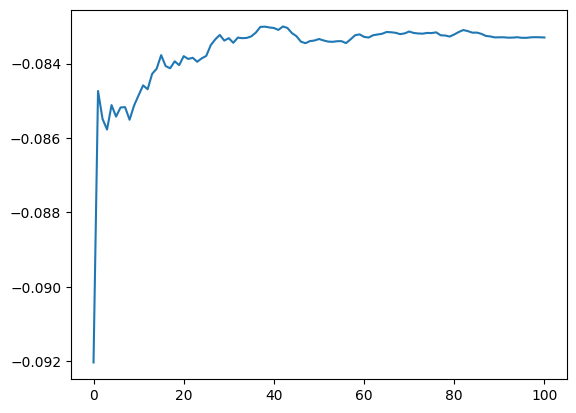

In [149]:
scores = rfe.cv_results_["mean_test_score"]
plt.plot(np.arange(len(scores)), scores)
plt.show()

without value

In [142]:
### TRAINING

labeled = eumf_pipeline.prepare_data(
    panel_comb_3m_macro,
    columns=["gdp", "unempl"] + selected_keyword_ids,
    lags=[1, 2, 3, 4, 5, 6, 7, 8],
    alternate_lags={
        "value": [2, 3, 4, 5, 6, 7, 8],
        "gdp": [2, 3, 4, 5, 6, 7, 8],
        "unempl": [2, 3, 4, 5, 6, 7, 8],
    },
    t_min=T_MIN,
    t_max=T_MAX,
)
# labeled.x = labeled.x[[f for f in selected_features if f in labeled.x.columns]]
transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test, extra_column=False)

rfe = feature_selection.RFECV(
    ensemble.RandomForestRegressor(random_state=42, min_samples_leaf=10),
    step=1,
    cv=cv_default,
    scoring=eumf_eval.scorer_mae,
    verbose=1,
    n_jobs=6,
)
rfe.fit(train_stacked.x, train_stacked.y)

# tuner = eumf_pipeline.train_reg_model(
#     train_stacked,
#     reg=linear_model.LinearRegression(),
#     extra_pipeline_steps=[preprocessing.StandardScaler()],
#     params=params,
#     scoring=eumf_eval.scorer_rmse,
#     cv=cv_default
# )

# cv_score = eumf_eval.score_cv(tuner.best_estimator_, train_stacked, cv=cv_default,)

# test_score = eumf_eval.score_test(tuner.best_estimator_, test_stacked,)


Fitting estimator with 94 features.
Fitting estimator with 94 features.
Fitting estimator with 94 features.
Fitting estimator with 94 features.
Fitting estimator with 94 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 93 features.
Fitting estimator with 93 features.
Fitting estimator with 93 features.
Fitting estimator with 93 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 92 features.
Fitting estimator with 92 features.
Fitting estimator with 92 features.
Fitting estimator with 92 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 91 features.
Fitting estimator with 91 features.
Fitting estimator with 91 features.
Fitting estimator with 91 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 90 features.
Fitting estimator with 90 features.
Fitting estimator with 90 fe

RFECV(cv=<eumf_eval.BlockKFold object at 0x7f23511ac430>,
      estimator=RandomForestRegressor(min_samples_leaf=10, random_state=42),
      n_jobs=6,
      scoring=make_scorer(mean_absolute_error, greater_is_better=False),
      verbose=1)

In [143]:
rfe.get_feature_names_out()

array(['115_2', '115_3', '115_6', '117_1', '117_2', '117_3', '118_2',
       '118_3', '118_5', '118_6', '118_7', '118_8', '119_1', '119_5',
       '119_6', '119_7', '119_8', '123_3', '123_4', '123_5', '123_8',
       '124_1', '124_6', '124_8', '19_1', '19_2', '19_3', '19_4', '19_5',
       '19_6', '19_7', '19_8', '39_5', 'gdp_2', 'unempl_2', 'unempl_3',
       'unempl_4', 'unempl_5', 'unempl_6', 'unempl_7', 'unempl_8'],
      dtype=object)

In [144]:
rfe.ranking_

array([30,  1,  1, 18, 12,  1,  4, 24,  1,  1,  1, 29, 14, 13, 36,  7, 27,
        1,  1,  3,  1,  1,  1,  1,  1, 19, 10,  9,  1,  1,  1,  1, 33, 15,
        1,  1,  1, 17, 32,  1,  1, 23, 28,  8, 43,  1, 35,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  2, 26, 11, 25, 16, 44, 41, 38, 37, 45, 46, 49,
       47, 54, 48, 52, 20, 40, 53, 50,  1, 51, 42, 31,  1,  6, 22, 34, 39,
       21,  5,  1,  1,  1,  1,  1,  1,  1])

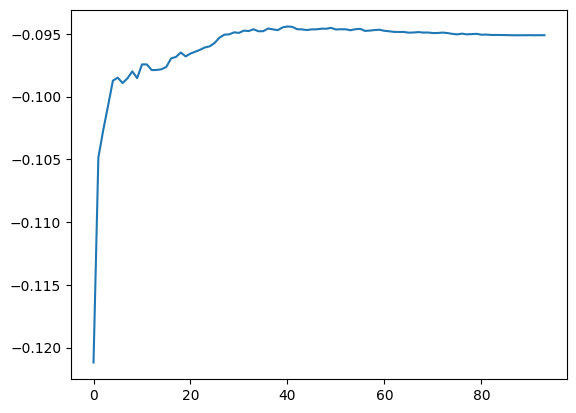

In [145]:
scores = rfe.cv_results_["mean_test_score"]
plt.plot(np.arange(len(scores)), scores)
plt.show()

without Google

In [154]:
### TRAINING

labeled = eumf_pipeline.prepare_data(
    panel_comb_3m_macro,
    columns=["gdp", "unempl", "value"],
    lags=[1, 2, 3, 4, 5, 6, 7, 8],
    alternate_lags={
        "value": [2, 3, 4, 5, 6, 7, 8],
        "gdp": [2, 3, 4, 5, 6, 7, 8],
        "unempl": [2, 3, 4, 5, 6, 7, 8],
    },
    t_min=T_MIN,
    t_max=T_MAX,
)
# labeled.x = labeled.x[[f for f in selected_features if f in labeled.x.columns]]
transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test, extra_column=False)

rfe = feature_selection.RFECV(
    ensemble.RandomForestRegressor(random_state=42, min_samples_leaf=10),
    step=1,
    cv=cv_default,
    scoring=eumf_eval.scorer_mae,
    verbose=1,
    n_jobs=6,
)
rfe.fit(train_stacked.x, train_stacked.y)

# tuner = eumf_pipeline.train_reg_model(
#     train_stacked,
#     reg=linear_model.LinearRegression(),
#     extra_pipeline_steps=[preprocessing.StandardScaler()],
#     params=params,
#     scoring=eumf_eval.scorer_rmse,
#     cv=cv_default
# )

# cv_score = eumf_eval.score_cv(tuner.best_estimator_, train_stacked, cv=cv_default,)

# test_score = eumf_eval.score_test(tuner.best_estimator_, test_stacked,)


Fitting estimator with 21 features.
Fitting estimator with 21 features.
Fitting estimator with 21 features.
Fitting estimator with 21 features.
Fitting estimator with 21 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 20 features.
Fitting estimator with 20 features.
Fitting estimator with 20 features.
Fitting estimator with 20 features.
Fitting estimator with 20 features.Fitting estimator with 19 features.

Fitting estimator with 19 features.
Fitting estimator with 19 features.
Fitting estimator with 19 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 18 features.
Fitting estimator with 18 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 17 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 17 fe

RFECV(cv=<eumf_eval.BlockKFold object at 0x7f23511ac430>,
      estimator=RandomForestRegressor(min_samples_leaf=10, random_state=42),
      n_jobs=6,
      scoring=make_scorer(mean_absolute_error, greater_is_better=False),
      verbose=1)

In [155]:
rfe.get_feature_names_out()

array(['unempl_2', 'unempl_3', 'unempl_4', 'unempl_6', 'unempl_7',
       'value_2', 'value_3', 'value_4', 'value_8'], dtype=object)

In [156]:
rfe.ranking_

array([ 4, 11, 12,  7,  2,  8,  5,  1,  1,  1, 10,  1,  1,  9,  1,  1,  1,
       13,  3,  6,  1])

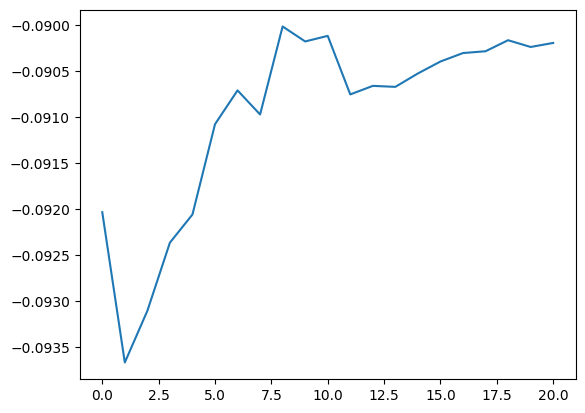

In [157]:
scores = rfe.cv_results_["mean_test_score"]
plt.plot(np.arange(len(scores)), scores)
plt.show()

In [160]:
pd.Series(rfe.estimator_.feature_importances_, index=rfe.get_feature_names_out()).sort_values(ascending=False)

value_2     0.747
value_4     0.057
unempl_3    0.047
unempl_2    0.033
unempl_6    0.027
unempl_4    0.024
value_3     0.023
unempl_7    0.022
value_8     0.021
dtype: float64

### Sequential feature selection

all features

In [192]:
### TRAINING

params = {}

labeled = eumf_pipeline.prepare_data(
    panel_comb_3m_macro,
    columns=["value", "gdp", "unempl"] + selected_keyword_ids,
    lags=[1, 2, 3, 4, 5, 6, 7, 8],
    alternate_lags={
        "value": [2, 3, 4, 5, 6, 7, 8],
        "gdp": [2, 3, 4, 5, 6, 7, 8],
        "unempl": [2, 3, 4, 5, 6, 7, 8],
    },
    t_min=T_MIN,
    t_max=T_MAX,
)
# labeled.x = labeled.x[selected_features]
transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test, extra_column=False)


sfs = mlxfs.SequentialFeatureSelector(
    linear_model.LinearRegression(),
    k_features=(1,32),
    forward=True,
    floating=True,
    verbose=1,
    scoring=eumf_eval.scorer_mae,
    cv=cv_default,
    n_jobs=-1,
    pre_dispatch="2n_jobs",
)

sfs.fit(train_stacked.x, train_stacked.y)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  74 out of 101 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    1.3s finished
Features: 1/32[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished
Features: 2/32[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  72 out of  99 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished
Features: 3/32[Parallel(n_jobs=-1)]:

SequentialFeatureSelector(cv=<eumf_eval.BlockKFold object at 0x7f23511ac430>,
                          estimator=LinearRegression(), floating=True,
                          k_features=(1, 32), n_jobs=-1, pre_dispatch='2n_jobs',
                          scoring=make_scorer(mean_absolute_error, greater_is_better=False),
                          verbose=1)

In [193]:
sfs.k_feature_names_

('117_3',
 '117_4',
 '117_7',
 '117_8',
 '118_6',
 '118_8',
 '123_4',
 '123_7',
 '123_8',
 '124_3',
 '19_1',
 '19_2',
 '19_3',
 '19_5',
 '19_8',
 '24_5',
 '24_8',
 '28_2',
 '39_1',
 '39_3',
 '39_6',
 'unempl_2',
 'unempl_6',
 'value_2',
 'value_4',
 'value_5',
 'value_6',
 'value_8')

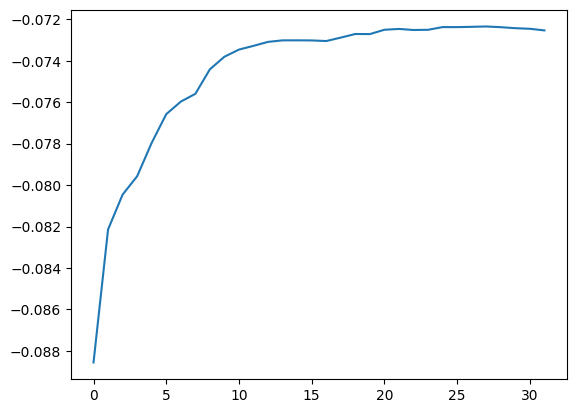

In [194]:
pd.Series([val["avg_score"] for key, val in sfs.subsets_.items()]).plot()
plt.show()

In [195]:
vif_data = pd.DataFrame()
vif_data["feature"] = sfs.k_feature_names_

vif_data["VIF"] = [
    variance_inflation_factor(train_stacked.x[list(sfs.k_feature_names_)].values, i)
    for i in range(len(sfs.k_feature_names_))
]

vif_data.sort_values(by="VIF", ascending=False)


,feature,VIF
25,value_5,7.259
26,value_6,6.490
24,value_4,6.275
23,value_2,3.773
27,value_8,2.955
22,unempl_6,2.585
21,unempl_2,2.371
7,123_7,2.226
8,123_8,2.169
2,117_7,2.119


without value

In [183]:
### TRAINING

params = {}

labeled = eumf_pipeline.prepare_data(
    panel_comb_3m_macro,
    columns=["gdp", "unempl"] + selected_keyword_ids,
    lags=[1, 2, 3, 4, 5, 6, 7, 8],
    alternate_lags={
        "value": [2, 3, 4, 5, 6, 7, 8],
        "gdp": [2, 3, 4, 5, 6, 7, 8],
        "unempl": [2, 3, 4, 5, 6, 7, 8],
    },
    t_min=T_MIN,
    t_max=T_MAX,
)
# labeled.x = labeled.x[selected_features]
transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test, extra_column=False)


sfs = mlxfs.SequentialFeatureSelector(
    linear_model.LinearRegression(),
    k_features=(1,32),
    forward=True,
    floating=True,
    verbose=1,
    scoring=eumf_eval.scorer_mae,
    cv=cv_default,
    n_jobs=-1,
    pre_dispatch="2n_jobs",
)

sfs.fit(train_stacked.x, train_stacked.y)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:    9.7s finished
Features: 1/32[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  66 out of  93 | elapsed:    1.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:    1.8s finished
Features: 2/32[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished
Features: 3/32[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done

SequentialFeatureSelector(cv=<eumf_eval.BlockKFold object at 0x7f23511ac430>,
                          estimator=LinearRegression(), floating=True,
                          k_features=(1, 32), n_jobs=-1, pre_dispatch='2n_jobs',
                          scoring=make_scorer(mean_absolute_error, greater_is_better=False),
                          verbose=1)

In [184]:
sfs.k_feature_names_

('118_2',
 '118_6',
 '118_8',
 '123_4',
 '123_5',
 '124_1',
 '19_1',
 '19_2',
 '19_3',
 '19_4',
 '19_5',
 '19_7',
 '28_2',
 '28_5',
 '39_5',
 '39_6',
 'gdp_8')

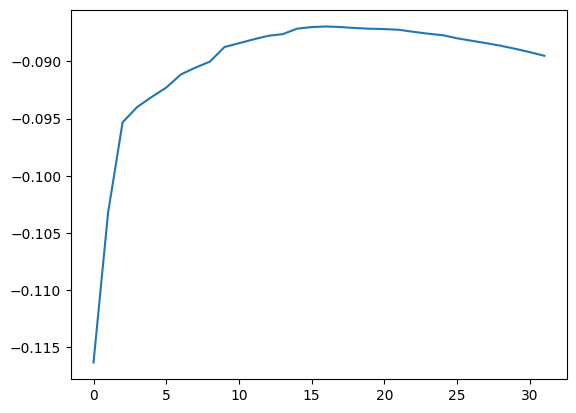

In [185]:
pd.Series([val["avg_score"] for key, val in sfs.subsets_.items()]).plot()
plt.show()

In [191]:
vif_data = pd.DataFrame()
vif_data["feature"] = sfs.k_feature_names_

vif_data["VIF"] = [
    variance_inflation_factor(train_stacked.x[list(sfs.k_feature_names_)].values, i)
    for i in range(len(sfs.k_feature_names_))
]

vif_data.sort_values(by="VIF", ascending=False)


,feature,VIF
10,19_5,2.040
8,19_3,1.965
7,19_2,1.940
6,19_1,1.919
9,19_4,1.859
4,123_5,1.719
3,123_4,1.622
11,19_7,1.512
12,28_2,1.462
2,118_8,1.424


without Google

In [197]:
### TRAINING

params = {}

labeled = eumf_pipeline.prepare_data(
    panel_comb_3m_macro,
    columns=["value", "gdp", "unempl"],
    lags=[1, 2, 3, 4, 5, 6, 7, 8],
    alternate_lags={
        "value": [2, 3, 4, 5, 6, 7, 8],
        "gdp": [2, 3, 4, 5, 6, 7, 8],
        "unempl": [2, 3, 4, 5, 6, 7, 8],
    },
    t_min=T_MIN,
    t_max=T_MAX,
)
# labeled.x = labeled.x[selected_features]
transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test, extra_column=False)


sfs = mlxfs.SequentialFeatureSelector(
    linear_model.LinearRegression(),
    k_features="best",
    forward=True,
    floating=True,
    verbose=1,
    scoring=eumf_eval.scorer_mae,
    cv=cv_default,
    n_jobs=-1,
    pre_dispatch="2n_jobs",
)

sfs.fit(train_stacked.x, train_stacked.y)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.5s finished
Features: 1/21[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished
Features: 2/21[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished
Features: 3/21[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  18 | elapse

SequentialFeatureSelector(cv=<eumf_eval.BlockKFold object at 0x7f23511ac430>,
                          estimator=LinearRegression(), floating=True,
                          k_features=(1, 21), n_jobs=-1, pre_dispatch='2n_jobs',
                          scoring=make_scorer(mean_absolute_error, greater_is_better=False),
                          verbose=1)

In [198]:
sfs.k_feature_names_

('gdp_2',
 'gdp_7',
 'unempl_3',
 'value_2',
 'value_3',
 'value_4',
 'value_6',
 'value_8')

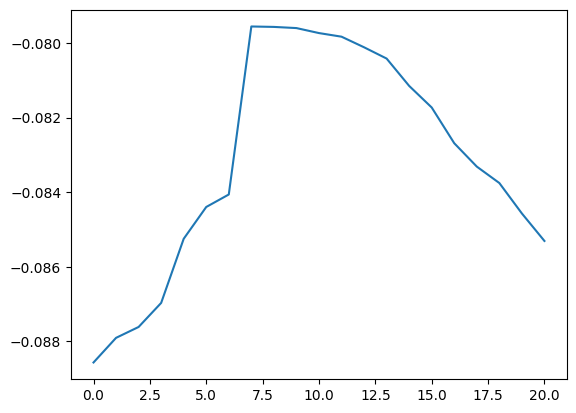

In [199]:
pd.Series([val["avg_score"] for key, val in sfs.subsets_.items()]).plot()
plt.show()

In [200]:
vif_data = pd.DataFrame()
vif_data["feature"] = sfs.k_feature_names_

vif_data["VIF"] = [
    variance_inflation_factor(train_stacked.x[list(sfs.k_feature_names_)].values, i)
    for i in range(len(sfs.k_feature_names_))
]

vif_data.sort_values(by="VIF", ascending=False)


,feature,VIF
4,value_3,6.689
5,value_4,5.483
6,value_6,4.529
3,value_2,4.407
7,value_8,2.593
2,unempl_3,2.043
0,gdp_2,1.513
1,gdp_7,1.269


### alternative dimensionality reduction

svd

In [236]:
### TRAINING

params = {"truncatedsvd__n_components": range(1, 32)}
# params={}

labeled = eumf_pipeline.prepare_data(
    panel_comb_3m_macro,
    columns=["value", "gdp", "unempl"] + selected_keyword_ids,
    lags=[1, 2, 3, 4, 5, 6, 7, 8],
    alternate_lags={
        "value": [2, 3, 4, 5, 6, 7, 8],
        "gdp": [2, 3, 4, 5, 6, 7, 8],
        "unempl": [2, 3, 4, 5, 6, 7, 8],
    },
    t_min=T_MIN,
    t_max=T_MAX,
)
transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

tuner = eumf_pipeline.train_reg_model(
    train_stacked,
    reg=linear_model.LinearRegression(),
    extra_pipeline_steps=[
        preprocessing.StandardScaler(),
        decomposition.TruncatedSVD(),
    ],
    params=params,
    scoring=eumf_eval.scorer_mae,
    cv=cv_default,
    dummy_encoder="drop",
)

print(tuner.best_params_)
print(tuner.best_score_)



{'truncatedsvd__n_components': 14}
-0.09270808808182879


PLS

In [237]:
### TRAINING

# params = {"plssvd__n_components": range(1, 32)}
params = {}

labeled = eumf_pipeline.prepare_data(
    panel_comb_3m_macro,
    columns=["value", "gdp", "unempl"] + selected_keyword_ids,
    lags=[1, 2, 3, 4, 5, 6, 7, 8],
    alternate_lags={
        "value": [2, 3, 4, 5, 6, 7, 8],
        "gdp": [2, 3, 4, 5, 6, 7, 8],
        "unempl": [2, 3, 4, 5, 6, 7, 8],
    },
    t_min=T_MIN,
    t_max=T_MAX,
)
transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test, extra_column=False)


tuner = model_selection.GridSearchCV(
    estimator=cross_decomposition.PLSRegression(n_components=2),
    param_grid={"n_components": np.arange(1,32)},
    scoring=eumf_eval.scorer_mae,
    cv=cv_default
)
tuner.fit(train_stacked.x, train_stacked.y)

print(tuner.best_params_)
print(tuner.best_score_)


{'n_components': 2}
-0.0919664676330843
